In [1]:
%run ../00_default_options.ipynb

In [19]:
import matplotlib.pyplot as plt
from robotehr.models.cohort import Cohort
import seaborn as sns

In [78]:
from fiber.condition import Patient

def bars(series, ax, rotate_labels_by=None, **kwargs):
    sns.countplot(series, ax=ax, **kwargs)
    if rotate_labels_by:
        plt.setp(ax.get_xticklabels(), rotation=rotate_labels_by)
        
def hist(series, ax, rotate_labels_by=None, **kwargs):
    sns.distplot(series, ax=ax, **kwargs)
    if rotate_labels_by:
        plt.setp(ax.get_xticklabels(), rotation=rotate_labels_by)

In [11]:
cohort = Cohort.load(id=1).get_fiber()

In [84]:
 """
Generates basic cohort demographics for patients' age and
gender distribution, including plots.
"""
condition_events = cohort.occurrences
s_age = condition_events[
    condition_events.age_in_days < 50000
].groupby(
    'medical_record_number'
).age_in_days.mean().apply(lambda x: x / 365).rename('Age in years')

patients_df = cohort.get(Patient(map_values=True))

Fetching data for Patient (...)


In [219]:
plt.rcParams['text.usetex'] = True 
plt.rcParams['text.latex.preamble'] = [r'\usepackage[cm]{sfmath}']
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'cm'
plt.rcParams['font.size'] = 14

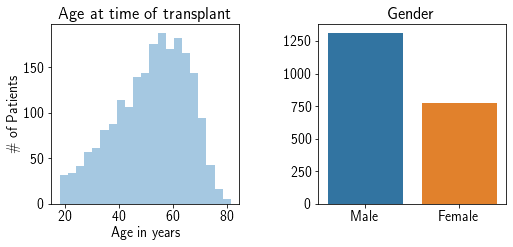

In [220]:
fig, ax = plt.subplots(1,2, figsize=[8,4])
fig.tight_layout(pad=3.0)

hist(s_age, ax=ax[0], norm_hist=False, kde=False)

ax[0].set_ylabel("\# of Patients", fontsize=14)
ax[0].set_xlabel('Age in years', fontsize=14)
ax[0].set_title('Age at time of transplant')


patients_df = patients_df[patients_df.gender != 'NOT AVAILABLE']
bars(patients_df.gender, ax=ax[1])
ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].set_title('Gender')

fig.savefig('/home/martet02/cohort-demographics-1.pdf', bbox_inches='tight')

In [60]:
import numpy as np

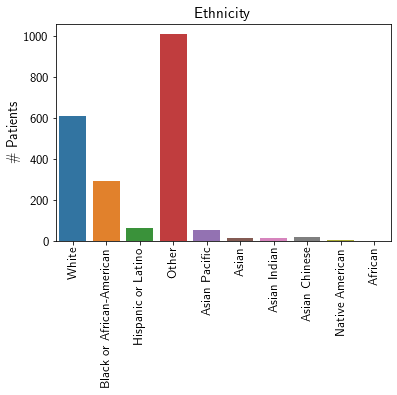

In [109]:
fig, ax = plt.subplots(1,1, figsize=[6,4])

bars(
    patients_df.race.str.replace('RaceType.', ''),
    rotate_labels_by=90,
    ax=ax,
)
ax.set_title('Ethnicity')
ax.set_xlabel('')
ax.set_ylabel('\# Patients', fontsize=14)

fig.savefig('/home/martet02/cohort-demographics-2.pdf', bbox_inches='tight')

In [128]:
from fiber.condition import Diagnosis
from fiberutils.condition_utils import _fetch_data

In [142]:
cmv_cond = Diagnosis(code='078.5', context='ICD-9') | Diagnosis(code=['B25%'], context='ICD-10')
cmv_longitudinality = _fetch_data(
    cohort=cohort, 
    condition=cmv_cond,
    lower_limit=-361,
    upper_limit=365
)

uti_cond = Diagnosis(code='599.0', context='ICD-9') | Diagnosis(code=['N39.0'], context='ICD-10')
uti_longitudinality = _fetch_data(
    cohort=cohort, 
    condition=uti_cond,
    lower_limit=-361,
    upper_limit=365
)

ovi_cond = Diagnosis(
    code=[
        'B33.%',   # other
        'B34.%',   # unspecified
        'B27.90',  # Infectious mononucleosis, unspecified without complication (EBV)
        'B97.89',  # Other viral agents as the cause of diseases classified elsewhere, BK virus
        'B15.%',   # HAV
        'B16.%',   # HBV
        'B17.%',   # other acute viral hepatitis (including HCV)
        'B18.%',   # chronic hepatitis
        'B19.%',   # unspecified chronic hepatitis
        'B20',     # HIV
        'B02.%',   # Varicella Zoster 
    ], 
    context='ICD-10'
) | Diagnosis(
    code=[
        '070.%',
        '071.%',
        '072.%',
        '073.%',
        '074.%',
        '075.%',
        '076.%',
        '077.%',
        '078.%',
        '079.%',
        '042',     # HIV
        '053.%',   # Varicella Zoster
    ],
    context='ICD-9'
)
ovi_longitudinality = _fetch_data(
    cohort=cohort, 
    condition=ovi_cond,
    lower_limit=-361,
    upper_limit=365
)

Fetching data for <fiber.condition.mrns.MRNs object at 0x7fddb37ad9b0>
Fetching data for Diagnosis (...)
Fetching data for <fiber.condition.mrns.MRNs object at 0x7fddb37ad9b0>
Fetching data for Diagnosis (...)
Fetching data for <fiber.condition.mrns.MRNs object at 0x7fddb37ad9b0>
Fetching data for Diagnosis (...)


In [145]:
def transform(x):
    a = min(x.time_delta_in_days)
    if a != 0:
        return a

In [170]:
uti_longitudinality.time_delta_in_days.max(),

(364.0,)

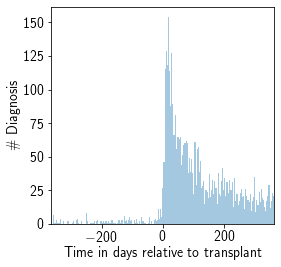

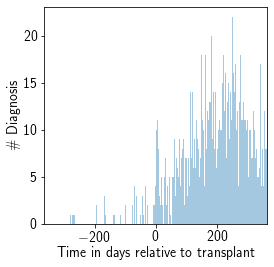

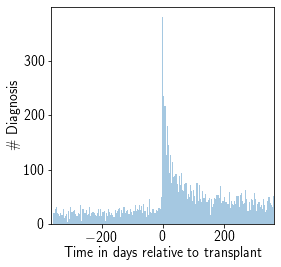

In [172]:
fig, ax = plt.subplots(1,1, figsize=[4,4])

hist(uti_longitudinality.time_delta_in_days, ax=ax, norm_hist=False, kde=False, bins=200)
ax.set_xlabel('Time in days relative to transplant', fontsize=14)
ax.set_ylabel('\# Diagnosis', fontsize=14)
ax.set_xlim([-365,365])
fig.savefig('/home/martet02/longitudinality-analysis-uti.pdf', bbox_inches='tight')


fig, ax = plt.subplots(1,1, figsize=[4,4])

hist(cmv_longitudinality.time_delta_in_days, ax=ax, norm_hist=False, kde=False, bins=200)
ax.set_xlabel('Time in days relative to transplant', fontsize=14)
ax.set_ylabel('\# Diagnosis', fontsize=14)
ax.set_xlim([-365,365])
fig.savefig('/home/martet02/longitudinality-analysis-cmv.pdf', bbox_inches='tight')


fig, ax = plt.subplots(1,1, figsize=[4,4])

hist(ovi_longitudinality.time_delta_in_days, ax=ax, norm_hist=False, kde=False, bins=200)
ax.set_xlabel('Time in days relative to transplant', fontsize=14)
ax.set_ylabel('\# Diagnosis', fontsize=14)
ax.set_xlim([-365,365])
fig.savefig('/home/martet02/longitudinality-analysis-ovi.pdf', bbox_inches='tight')

In [173]:
import pandas as pd

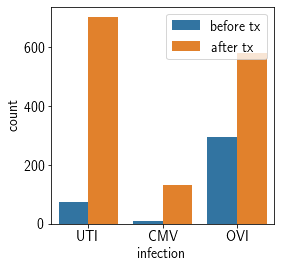

In [217]:
fig, ax = plt.subplots(1,1, figsize=[4,4])

df = pd.DataFrame([
    *[{'infection': 'UTI', '': 'before tx'} for x in range(74)],
    *[{'infection': 'UTI', '': 'after tx'} for x in range(703)],
    *[{'infection': 'CMV', '': 'before tx'} for x in range(10)],
    *[{'infection': 'CMV', '': 'after tx'} for x in range(133)],
    *[{'infection': 'OVI', '': 'before tx'} for x in range(294)],
    *[{'infection': 'OVI', '': 'after tx'} for x in range(582)],
])

sns.countplot(x="infection", hue="", data=df, ax=ax)
ax.set_ylabel('\# Patients')
ax.set_xlabel('Infection')